# ICE Membership Inference Experiments

In [1]:
import pandas as pd
import sklearn.ensemble as es
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import logging

In [2]:
threads = 15

In [3]:
%run experiment_setup.ipynb

INFO:xai-privacy:Loading dataset 1: heart disease (numeric features) ...
INFO:xai-privacy:Loading dataset 2: census income (categorical features) ...


In [4]:
logger = logging.getLogger('xai-privacy')

This notebook will go through the experiment for membership inference with individual conditional expectation (ICE). Membership inference means an attacker with access to the explanation can tell with high confidence for any sample whether it was included in the training data or not.

The idea for ICE membership inference is as follows: The attacker can recreate the ICE lines for any sample and check whether they occur in the given explanation. If they do, there is a high chance that the sample was used in the training data (which was also used to create the ICE explanation). Otherwise the sample was not included in the training data.

First, we implement the `train_explainer` and `membership_inference_attack_model_access` functions:

In [5]:
class IceMembershipInference(MembershipInference):
    def train_explainer(self, data_train, model):
        # Calculate ICE
        ice_features = []

        for i in range(self.features.shape[1]):
            logger.debug(f'Calculating ICE for feature {i}')
            ice_features.append(partial_dependence(estimator=model, X=data_train.drop(self.outcome_name, axis=1), 
                                                   features=[i], percentiles=(0,1), kind='individual'))
            
        return ice_features
        
    @staticmethod
    def membership_inference_attack_model_access(explainer, samples_df, model):
        # we only use the features for membership inference, not the target. Therefore we must drop the last column.
        samples_df = samples_df.drop(samples_df.columns[-1], axis=1)
        samples = samples_df.to_numpy()
        ice_features = explainer
        pred_func = model.predict_proba
        columns = samples_df.columns
        
        results = np.empty(samples.shape[0])

        for i in range(samples.shape[0]):

            sample = samples[i]

            logger.debug(f'Checking sample {i}: {sample}')

            for num, ice in enumerate(ice_features):

                # Get the grid for this feature. These are the points at which we will get predictions from the model.
                feature_values = ice['values'][0]

                # Create array that contains the sample as many times as there are different grid points for this feature.
                changed_samples = np.tile(sample, (feature_values.shape[0], 1))

                # Change each copied samples feature in question to a point from the grid.
                changed_samples[:, num] = feature_values

                # create pandas dataframe from numpy array
                changed_samples_df = pd.DataFrame(changed_samples, columns=columns)

                # Get the predictions for these changed samples.
                preds = pred_func(changed_samples_df)[:, 1]

                # First, create array with boolean values whether the recreated predictions and the actual ICE predictions match.
                # Then check if there is any row where all elements are true. 
                # That means there is at least one ICE line with identical predictions.
                res = np.isclose(preds, ice['individual'][0], rtol=1e-03).all(1).any()

                # If there is no identical ICE line for this feature, the sample can't be part of the training data.
                # Break out of loop. res is false and will be appended to the list of results.
                if res == False:
                    logger.debug(f'Recreated ICE line for feature {num} does not match.')
                    break;
                logger.debug(f'Recreated ICE line for feature {num} matches.')

            logger.debug(f'Inferred membership as {res}')

            # This appends the last res to the results list. If a matching line for every feature was found, this is true 
            # (sample is in training data). Otherwise the last res will be false (sample is not in training data)
            results[i] = res

        return results

# Executing Membership Inference

Before running the experiment, we we will have a short look at the visual explanation of ICE. The underlying data of these graphs will be our attack vector for membership inference.

The light blue lines are the change in prediction for single samples from the training data. These are the ICE lines for individual samples from the training data.

In [6]:
# Train a random forest model on training data.
features = data_heart.drop(outcome_name_heart, axis=1)
labels = data_heart[outcome_name_heart]

model = es.RandomForestClassifier(random_state=0)
model = model.fit(features, labels)

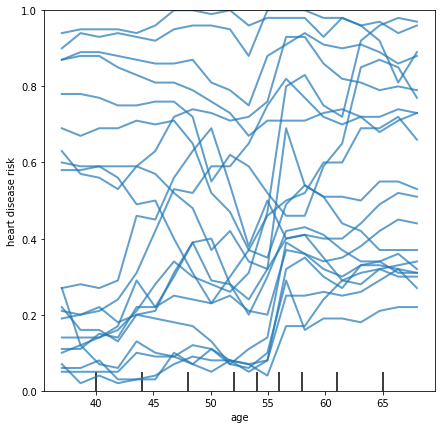

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))

display = PartialDependenceDisplay.from_estimator(
       estimator=model, X=features, features=[0], feature_names=['age'], kind="individual", subsample=20,
       n_jobs=3, ice_lines_kw = { 'alpha' : 0.7, 'linewidth' : 2.0 }, grid_resolution=20, random_state=0, percentiles = (0.05, 0.95), ax=ax
)

plt.ylabel("heart disease risk")
plt.xlabel("age")

plt.show()

As a proof of concept for our privacy attack, we run the experiment with a very small amount of repetitions with logging to show that the membership inference function works in principle.

In [8]:
logger.setLevel(logging.DEBUG)

EXP = IceMembershipInference(data_heart, numeric_features_heart, outcome_name_heart, random_state=0)
EXP.membership_inference_experiment(num_queries=8, model=es.RandomForestClassifier(random_state=0), model_access=True, threads=1)

logger.setLevel(logging.INFO)

DEBUG:xai-privacy:Calculating ICE for feature 0
DEBUG:xai-privacy:Calculating ICE for feature 1
DEBUG:xai-privacy:Calculating ICE for feature 2
DEBUG:xai-privacy:Calculating ICE for feature 3
DEBUG:xai-privacy:Calculating ICE for feature 4
DEBUG:xai-privacy:[[ 46. 110. 240. 140.   0.   0.]] taken from training data
DEBUG:xai-privacy:[[ 57.  128.  229.  150.    0.4   1. ]] taken from test data
DEBUG:xai-privacy:[[ 56.  140.    0.  121.    1.8   1. ]] taken from training data
DEBUG:xai-privacy:[[ 67.  120.    0.  150.    1.5   1. ]] taken from test data
DEBUG:xai-privacy:[[ 58. 128. 259. 130.   3.   1.]] taken from training data
DEBUG:xai-privacy:[[ 35. 126. 282. 156.   0.   1.]] taken from test data
DEBUG:xai-privacy:[[ 71.  160.  302.  162.    0.4   0. ]] taken from training data
DEBUG:xai-privacy:[[ 51.  140.  299.  173.    1.6   1. ]] taken from test data
DEBUG:xai-privacy:Checking sample 0: [ 46. 110. 240. 140.   0.]
DEBUG:xai-privacy:Recreated ICE line for feature 0 matches.
DEBUG:

Total time: 6.13s (training model: 0.14s, training explainer: 5.51s, experiment: 0.48s)
Accuracy: 1.0, precision: 1.0, recall: 1.0


The proof of concept should show that the membership inference function predicts membership very accurately. You can change the random state to try out a few different runs with different chosen samples.

Now we begin executing the actual experiment. We begin by defining the table that will hold the results for all our different experiment variations. Then we execute all variations of the experiment for this dataset. We vary the model between a decision tree, a random forest and a neural network. Each model uses the default configuration of scikit-learn.

In [9]:
results_ = {'dataset': [], 'model': [], 'accuracy': [], 'precision': [], 'recall': []}

results = pd.DataFrame(data = results_)

In [30]:
dataset_dicts = [data_heart_dict, data_heart_num_dict, data_heart_cat_dict, data_census_dict, data_census_num_dict, data_census_cat_dict]

dt_dict = {'name': 'decision tree', 'model': DecisionTreeClassifier}
rf_dict = {'name': 'random forest', 'model': es.RandomForestClassifier}
nn_dict = {'name': 'neural network', 'model': MLPClassifier}

model_dicts = [dt_dict, rf_dict, nn_dict]

In [ ]:
# This will run the experiment for each dataset and model combination

results = run_all_experiments(IceMembershipInference, dataset_dicts, model_dicts, random_state=0, num_queries=None, model_access=True, threads=threads, results_table=results)

dataset: heart, model: decision tree
Total time: 3.40s (training model: 0.02s, training explainer: 3.12s, experiment: 0.25s)
Accuracy: 0.6416464891041163, precision: 0.5825105782792666, recall: 1.0
dataset: heart, model: random forest


# Results

The results of all variations of the membership inference experiment with ICE. In every experiment, we executed the membership inference attack on each sample of the training data and each sample of the test data. Both datasets are of equal size and originate from the same source dataset.

Accuracy is the percentage of samples whose membership (true or false) was correctly inferred. An algorithm guessing at random would achieve an accuracy of 50 percent.

Precision is the percentage of predicted training samples that is actually in the training data.

Recall is the percentage of training samples whose membership (true) was correctly inferred.

In [19]:
results

,dataset,model,accuracy,precision,recall
0,numeric,decision tree,0.535194,0.518239,1.000000
1,numeric,random forest,1.000000,1.000000,1.000000
2,numeric,neural network,1.000000,1.000000,1.000000
3,categorical,decision tree,0.511267,0.505697,1.000000
4,categorical,random forest,0.998575,0.997159,1.000000
5,categorical,neural network,0.999352,0.998707,1.000000
6,mixed,decision tree,0.529376,0.515133,1.000000
7,mixed,random forest,0.982443,0.966077,1.000000
8,mixed,neural network,0.985369,0.998828,0.971878


In [20]:
results.to_csv('results/1-3-ice-membership-inference-results.csv', index=False, na_rep='NaN', float_format='%.3f')

# Discussion

In our experiments, membership inference with ICE has an accuracy between 99% and 100% for a random forest and a neural network, and an accuracy between 51% and 53% for a decision tree. Since no false negatives can occur, recall is always 100%.

How do we explain the big difference in accuracy of the attack between a decision tree and a random forest or neural network? Have a look at the number of different predictions each model makes for the numeric dataset:

In [21]:
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = es.RandomForestClassifier(random_state=0)
neural_network = MLPClassifier(random_state=0)

x_train, y_train = data_num.drop(outcome_name_num, axis=1), data_num[outcome_name_num]

decision_tree.fit(x_train, y_train)
random_forest.fit(x_train, y_train)
neural_network.fit(x_train, y_train)

pred_decision_tree = decision_tree.predict_proba(x_train)[:, 1]
pred_random_forest = random_forest.predict_proba(x_train)[:, 1]
pred_neural_network = neural_network.predict_proba(x_train)[:, 1]

unique_pred_dt = np.unique(pred_decision_tree)
unique_pred_rf = np.unique(pred_random_forest)
unique_pred_nn = np.unique(pred_neural_network)

print(f'Unique predictions by decision tree: {unique_pred_dt} ({len(unique_pred_dt)}) \n')
print(f'Unique predictions by random forest: {unique_pred_rf} ({len(unique_pred_rf)}) \n')
print(f'Unique predictions by neural network: {unique_pred_nn} ({len(unique_pred_nn)}) \n')

Unique predictions by decision tree: [0. 1.] (2) 

Unique predictions by random forest: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.44 0.47 0.55 0.56 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ] (87) 

Unique predictions by neural network: [0.00549233 0.02100134 0.02323252 0.02512592 0.02725006 0.02801536
 0.03224527 0.0406329  0.04244417 0.04263699 0.05827152 0.05881957
 0.05887901 0.06156878 0.06636166 0.07382802 0.08644909 0.099212
 0.10740958 0.11486731 0.11685485 0.12361536 0.13122295 0.14238695
 0.14855312 0.14915165 0.15537691 0.15878044 0.16698216 0.17167648
 0.17999185 0.1799967  0.1812085  0.18610233 0.18912233 0.19025421
 0.19079436 0.19111423 0

The decision tree only makes two different kinds of predictions: 0 or 1. The random forest averages between all its trees and therefore can make a much higher number of different predictions, while the many neurons and weights in a neural network have an even stronger diversifying effect on the prediction. It is much more likely for two samples to have the same ICE lines if they can only be made up of two different prediction values. Therefore, the attack against the decision tree is much more likely to produce false positives. This explains the difference in accuracy well.